### DSA5105 Project

Author: Zhao Peiduo

AY2024/25 Sem 1

#### Quick Start

You can install the relevant dependencies by running the commands below in a virtual environment (recommended):

```
pip install ucimlrepo scikit-learn matplotlib seaborn
```

#### Summary of the Project Components

With Reference to the grading scheme, this project will cover 3 supervised learning techniques and 2 unsupervised learning techniques. In particular:
- Supervised Learning: Support Vector Machine(SVM), Neural Network(MLP), Random Forest (of Decision Trees)
- Unsupervised Learning: PCA(for feature selection), K-means, Gaussian Mixture Model(GMM)

The structure of the project is as follows:
1. Introduction and Dataset Overview
2. EDA and data preprocessing
3. Supervised Learning Methods
4. Unsupervised Learning Methods
5. Conclusion

#### Import the dataset and necessary libraries

In [193]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [194]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

#### 1. Introduction and Dataset Overview

The dataset used for this project is from UC Irvine Machine Learning Repository, containing data features for patients who are diagnosed with coronary artery disease (a form of heart disease) and patients who do not have such disease. 

This dataset contains both integer and categorical features, and the categorical features with more than two categories need to be one-hot encoded since its value does not represent a magnitude (which implies an order) but a category. This is to avoid the case that machine learning models interpret these features' numerical values literally and attempt to *regress* to the categorical values.

In [195]:
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


The feature set contains 13 unique features with 303 data points, which is relatively a small dataset. This would imply that we have to be more careful in feature exploration and selections so as to avoid the risk of overfitting and the curse of dimensionality due to too many features. 

In [196]:
print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


Drop entries with null values

In [197]:
X = X.loc[~X["thal"].isna() & ~X["ca"].isna()]
y = y.loc[X.index]  # Ensure y is filtered to match the indices of X

In terms of the class labels, there are 5 unique class labels given in the dataset. From the [documentation](https://archive.ics.uci.edu/dataset/45/heart+disease), 0 represents the absence of heart disease while 1 to 4 represents a presence (supposedly for different stages / intensity).

Given the small dataset size, this project will merge the four presence classes into a single class and reduce the task to binary classification: To predict if a patient has heart disease given the features.

In [198]:
y.value_counts()

num
0      160
1       54
2       35
3       35
4       13
Name: count, dtype: int64

After merging the four classes, we have 160 samples belonging to class 0 (absence) and 137 samples belonging to class 1 (presence).

In [199]:
y_binarized = y["num"].copy()
other_class_mask = y_binarized.isin([2, 3, 4]) 
y_binarized.iloc[other_class_mask] = 1
y_binarized.value_counts()

num
0    160
1    137
Name: count, dtype: int64

#### EDA and Data Preprocessing

This section visualizes and selects useful features for model training

Statistics for the feature set

In [200]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [201]:
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
X[categorical_features].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
thal       3
dtype: int64

In [202]:
multi_categorical_features = ["cp", "restecg", "slope", "thal"]

Data Visualization

We can visualize the numerical features by stacked histograms and categorical features by bar plots

Numerical Features

Notice that although ca looks like a categorical feature, the description of this feature is "number of major vessels (0-3) colored by flourosopy", which is a count and is ordered in nature

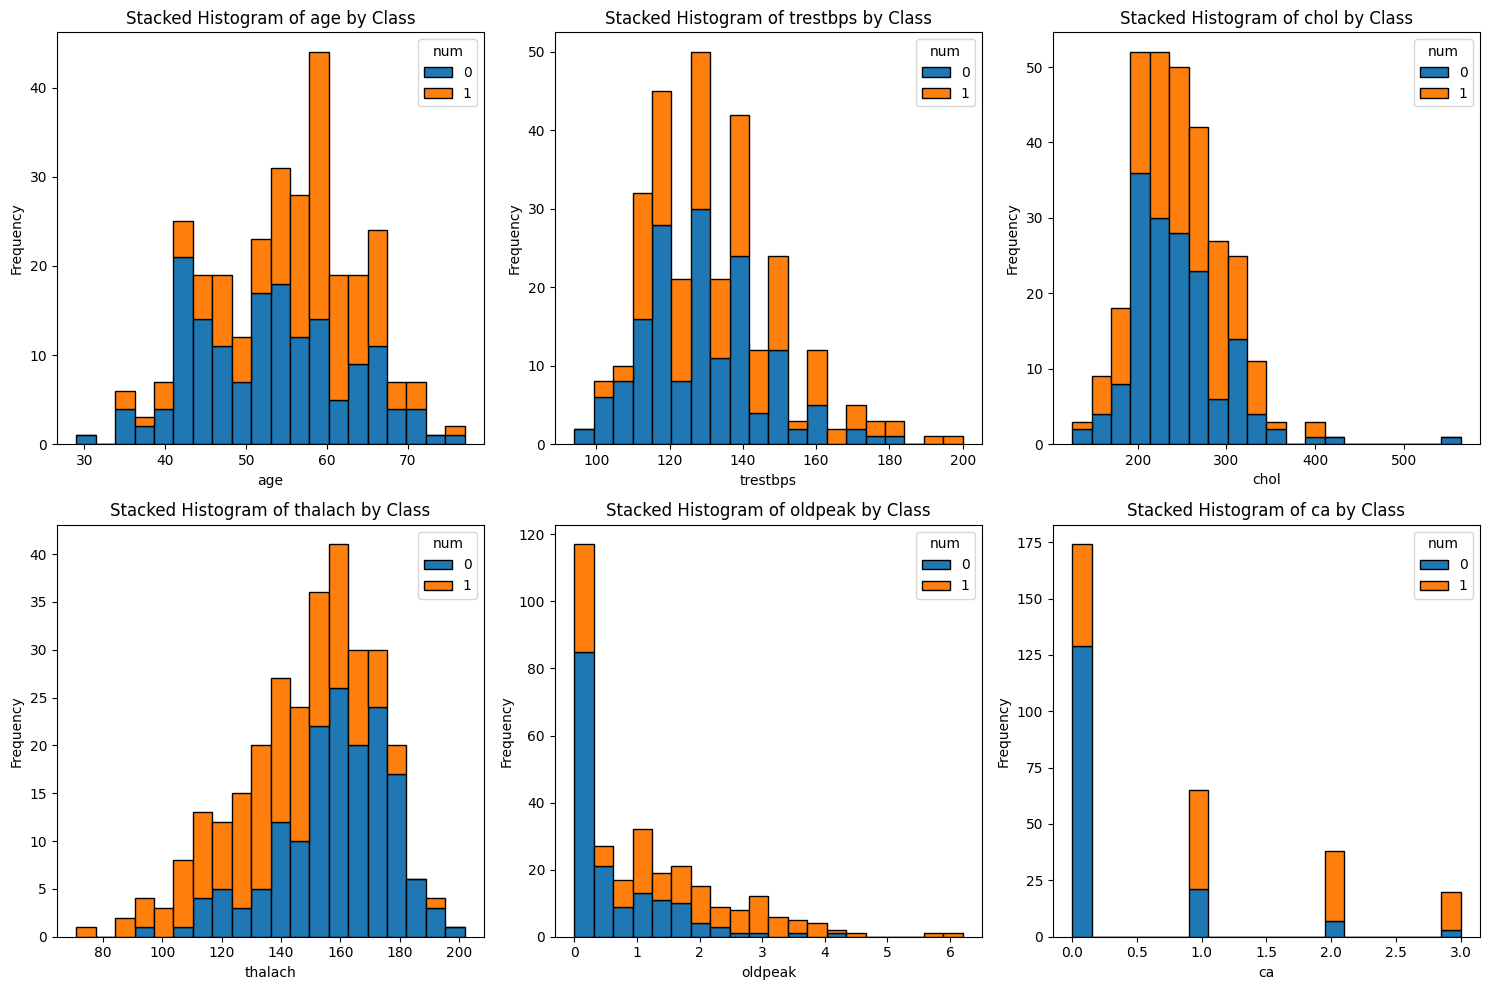

In [203]:
data = pd.concat([X, y_binarized], axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    class_data = [data[data["num"] == label][feature] for label in data["num"].unique()]
    labels = data["num"].unique()
    
    axes[i].hist(class_data, bins=20, stacked=True, label=labels, edgecolor='black')
    axes[i].set_title(f"Stacked Histogram of {feature} by Class")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")
    axes[i].legend(title="num")

for j in range(len(numerical_features), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Catgeorical Features

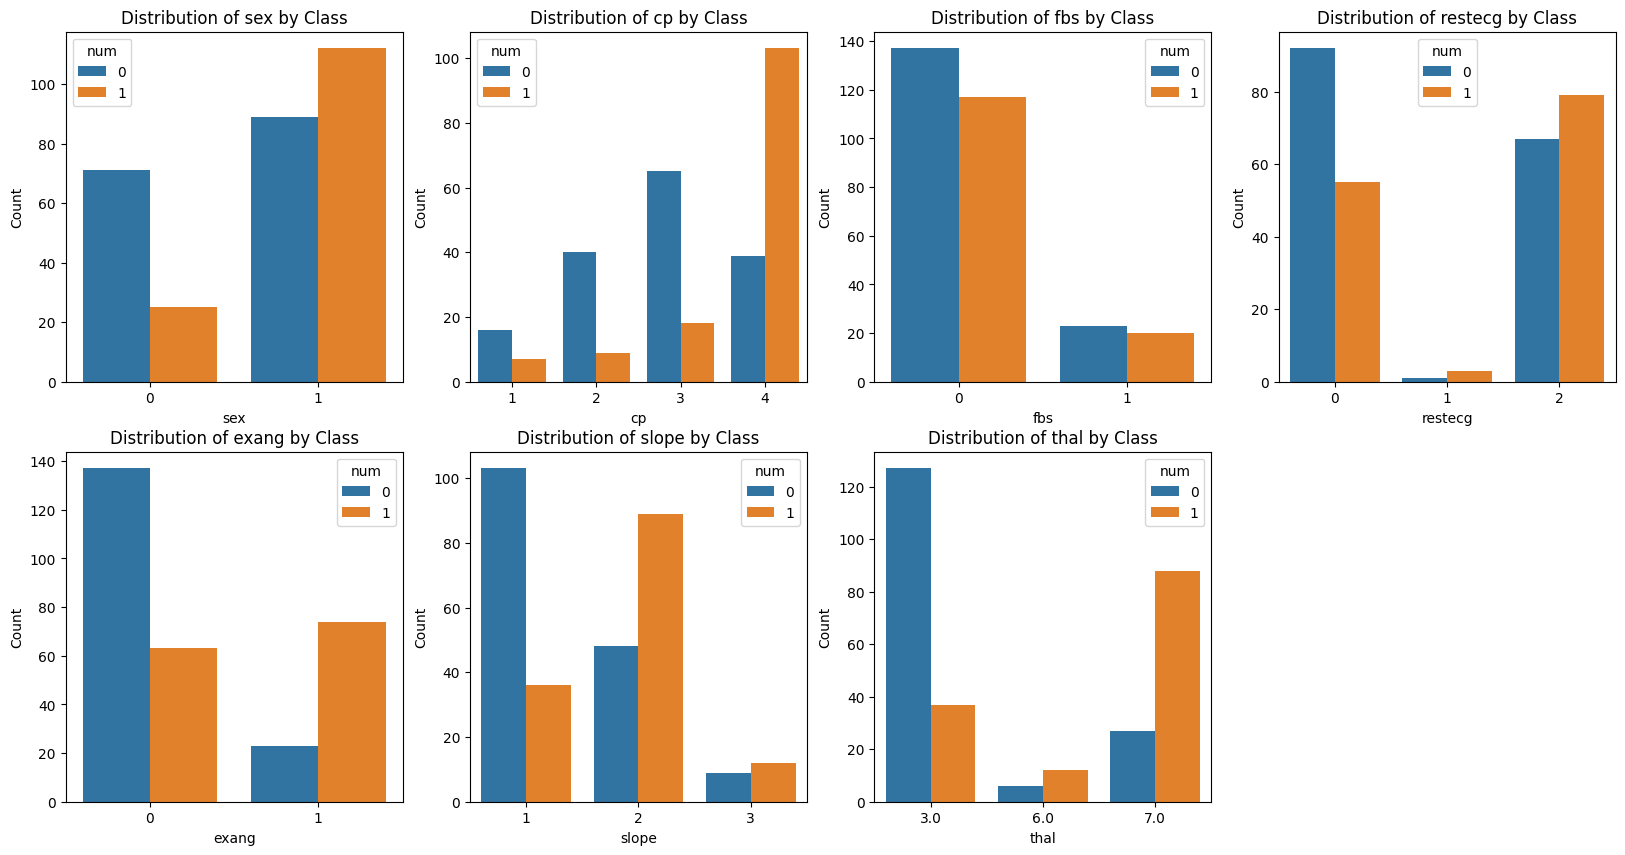

In [204]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=data, x=feature, hue="num", ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Class")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

for j in range(len(categorical_features), len(axes)):
    axes[j].axis("off")

plt.show()

One-hot Encoding (OHE) for multi-categorical features 

The deatiled explanation for what each category number represents variables table of the documentation. 

After OHE, we have 22 features in total

In [205]:
ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X[multi_categorical_features])
encoded_df = pd.DataFrame(X_encoded.toarray(), columns=ohe.get_feature_names_out(multi_categorical_features), index=X.index)
X_ohe = X.drop(columns=multi_categorical_features).join(encoded_df)
X_ohe.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1,...,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3,thal_3.0,thal_6.0,thal_7.0
0,63,1,145,233,1,150,0,2.3,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,67,1,160,286,0,108,1,1.5,3.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,67,1,120,229,0,129,1,2.6,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37,1,130,250,0,187,0,3.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,41,0,130,204,0,172,0,1.4,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


Feature Correlation Heatmap

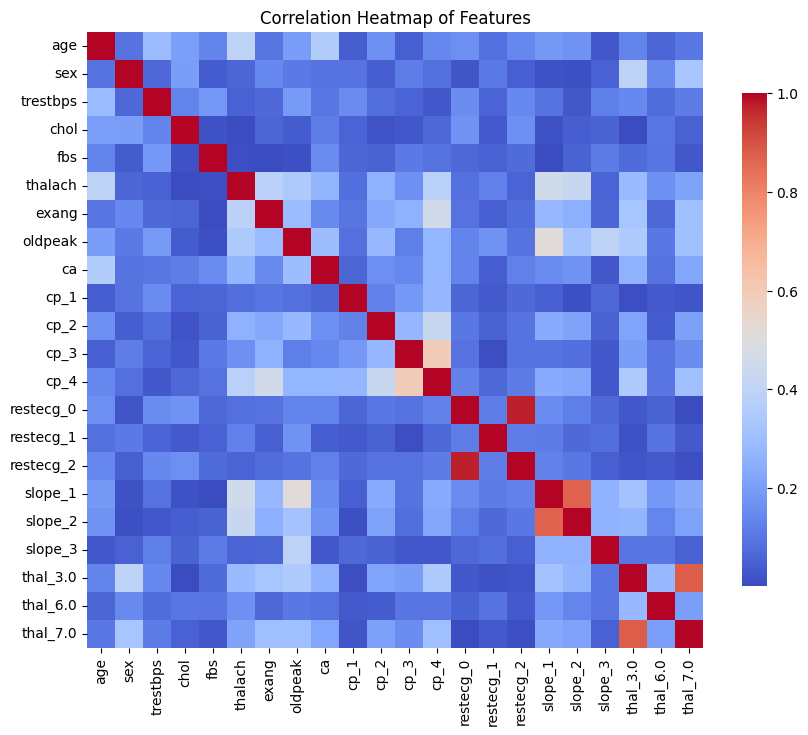

In [206]:
correlation_matrix = X_ohe.corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
plt.title("Correlation Heatmap of Features")
plt.show()

We see several highly correlated features, which can be identified by thresholding as well.

In [207]:
def find_highly_correlated_features(features, threshold=0.7):
    correlation_matrix = features.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    highly_correlated_pairs = [(col, row, upper_triangle.loc[row, col]) 
                            for col in upper_triangle.columns 
                            for row in upper_triangle.index 
                            if upper_triangle.loc[row, col] > threshold]
    return highly_correlated_pairs

In [208]:
find_highly_correlated_features(X_ohe) 

[('restecg_2', 'restecg_0', 0.9734216295491753),
 ('slope_2', 'slope_1', 0.8679189062626194),
 ('thal_7.0', 'thal_3.0', 0.882692282941067)]

Three highly correlated features identified. We drop the first entries. Now we are left with 19 features

In [209]:
X_ohe.drop(columns=["restecg_2", "slope_2", "thal_7.0"], inplace=True)

Perform PCA on the OHE feature set

First we set n_components to None to visualize the feature importance (in terms of variance explained) for all OHE features. 

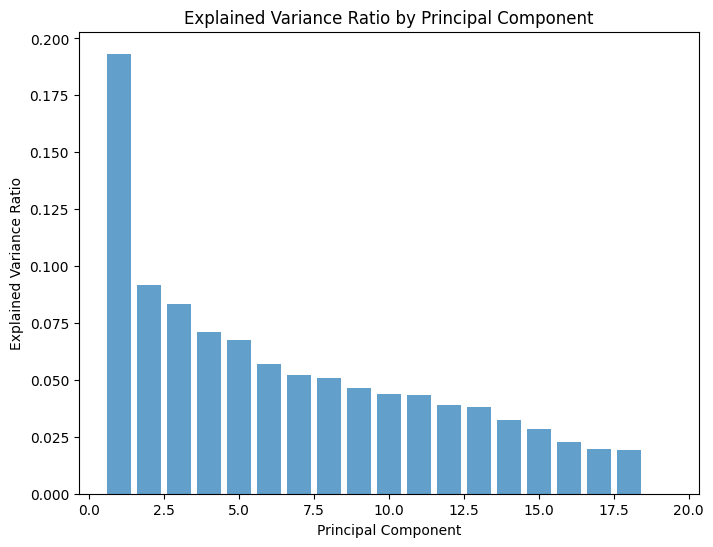

In [210]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ohe)

pca = PCA(n_components=None)

X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=X_ohe.columns)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()


We drop the features with feature importance less than 0.02 to further reduce the feature size

In [211]:
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_  
components_df = pd.DataFrame(pca.components_, columns=X_ohe.columns)

# Multiply each component's loadings by the explained variance ratio of that component, sort by importance
feature_importance_df = pd.DataFrame(np.abs(components_df.T @ explained_variance), index=X_ohe.columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

print("Top Features by Feature Importance based on PCA:")
pd.set_option('display.max_rows', None)  # Display all rows
print(feature_importance_df)
pd.reset_option('display.max_rows')

Top Features by Feature Importance based on PCA:
           Feature Importance
restecg_1            0.139293
trestbps             0.110090
thal_6.0             0.095158
slope_3              0.093465
oldpeak              0.088189
slope_1              0.081886
cp_2                 0.064809
thalach              0.057292
age                  0.055723
exang                0.051918
restecg_0            0.035414
thal_3.0             0.035071
cp_3                 0.033948
sex                  0.031229
fbs                  0.028429
cp_4                 0.012255
cp_1                 0.010099
chol                 0.009460
ca                   0.007568


In [212]:
X_ohe.drop(columns=["cp_4", "cp_1", "chol", "ca"], inplace=True)

Now we are left with 15 features after feature selection with PCA and we can start training the models

In [213]:
X_ohe.head()

,age,sex,trestbps,fbs,thalach,exang,oldpeak,cp_2,cp_3,restecg_0,restecg_1,slope_1,slope_3,thal_3.0,thal_6.0
0,63,1,145,1,150,0,2.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,67,1,160,0,108,1,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,67,1,120,0,129,1,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,37,1,130,0,187,0,3.5,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,41,0,130,0,172,0,1.4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Supervised Learning Model Training

Train test split with fixed random seed for reproducibility

Since the distribution of two classes is roughly even and we have limited data points, no resampling is conducted to fully balance the two classes

In [214]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_binarized, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model Training Methodology

To improve model performance and evaluate model performance through cross validation, we use GridSearch as the hyperparameter tuning technique for all the machine learning models below:

Supervised Learning:
- Support Vector Machine (SVM)
- Logistic Regression
- Random Forest (Ensemble of Decision Trees)
- Neural Network (NN)

Unsupervised Learning:
- K-means clustering
- Gaussian Mixture Model (GMM) 

We use both accuracy and F1-score to measure the model performance, so as to ensure the model performs well and perform fairly on both classes.

#### Supervised Learning Model Training

##### 1. SVM

Best training Accuracy = 0.78859

Test accuracy = 0.87

Test Macro F1-score = 0.86 

In [215]:
# Define the parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],               # Different regularization level
    'kernel': ['linear', 'rbf', 'poly'],  # Try different kernel variations
    'gamma': ['scale', 'auto']
}

# set max_iter to early stop when the perfectly separable 
svm = SVC(max_iter=200000)

# Initialize GridSearchCV with 10-fold cross validation
svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=10, scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Score:", svm_grid_search.best_score_)

y_pred = svm_grid_search.best_estimator_.predict(X_test)
print("Peformance on test data:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Score: 0.788586956521739
Peformance on test data:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

[[32  4]
 [ 4 20]]


##### 2. Logistic Regression

Best training Accuracy = 0.79293

Test accuracy = 0.87

Test Macro F1-score = 0.86 

In [216]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],         # Regularization strength
    'penalty': ['l2', 'none'],            # Regularization type
    'solver': ['lbfgs', 'saga']           # Solver (only solvers that support the chosen penalty)
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=2000)

# Initialize GridSearchCV
logreg_grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
logreg_grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
print("Best Logsitic Regression Parameters:", logreg_grid_search.best_params_)
print("Best Logsitic Regression Score:", logreg_grid_search.best_score_)

y_pred = svm_grid_search.best_estimator_.predict(X_test)
print("Peformance on test data:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best Logsitic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logsitic Regression Score: 0.7929347826086957
Peformance on test data:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

[[32  4]
 [ 4 20]]


##### 3. Random Forest of Decision Trees

Best training Accuracy = 0.78007

Test accuracy = 0.83

Test Macro F1-score =  0.83 

In [217]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],    # Number of decisions trees
    'max_depth': [None, 10, 20, 30],   # Max depth of tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
rf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
rf_grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best RF Parameters:", rf_grid_search.best_params_)
print("Best RF Score:", rf_grid_search.best_score_)

y_pred = rf_grid_search.best_estimator_.predict(X_test)
print("Peformance on test data:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best RF Score: 0.780072463768116
Peformance on test data:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        36
           1       0.79      0.79      0.79        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

[[31  5]
 [ 5 19]]


##### 4. Neural Network (MLP)

Best training Accuracy = 0.79293

Test accuracy = 0.88

Test Macro F1-score =  0.88

In [218]:
# Define the parameter grid
nn_param_grid = {
    'hidden_layer_sizes': [(32,), (32,), (32, 64), (32, 64)],  # Use a single hidden layer or two hidden layers
    'activation': ['relu', 'tanh', 'logistic'],                # For hidden layer 
    'alpha': [0.0001, 0.001, 0.01],                            # L2 regularization
    'learning_rate_init': [1e-3, 1e-4]
}

# Initialize the Neural Network model
nn = MLPClassifier(max_iter=500, solver='adam', learning_rate='constant', random_state=42)

# Initialize GridSearchCV
nn_grid_search = GridSearchCV(estimator=nn, param_grid=nn_param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the data
nn_grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best NN Parameters:", nn_grid_search.best_params_)
print("Best NN Score:", nn_grid_search.best_score_)

y_pred = nn_grid_search.best_estimator_.predict(X_test)
print("Peformance on test data:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best NN Parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate_init': 0.0001}
Best NN Score: 0.7929347826086957
Peformance on test data:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.87      0.83      0.85        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

[[33  3]
 [ 4 20]]


c:\Users\Andrew\envs\DSA5105\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Out of the four candidate models, the neural network performs the best after hyperparameter tuning. However, given the small train and test size, these results are not guaranteed to be generalisable when more data points become available.

#### Unsupervised Learning

We use the clustering techniques to predict the class labels by assigning them to one of the two clusters

##### 1. K-Means

Accuracy = 0.51

Macro F1-score =  0.38

While the model performs relatively decent on absence (0) data points, the performance is horrible on presence (1) data points

In [219]:
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
acc_pos = accuracy_score(y_binarized, kmeans_labels)
acc_neg = accuracy_score(y_binarized, 1 - kmeans_labels)
print(acc_pos, acc_neg) # acc_neg is larger, so that reversing the labels aligns cluster index with class labels
kmeans_labels = 1 - kmeans_labels
print("Classification Report and Confusion Matrix")
print(classification_report(y_binarized, kmeans_labels))
print(confusion_matrix(y_binarized, kmeans_labels))

0.49158249158249157 0.5084175084175084
Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.53      0.90      0.66       160
           1       0.30      0.05      0.09       137

    accuracy                           0.51       297
   macro avg       0.41      0.48      0.38       297
weighted avg       0.42      0.51      0.40       297

[[144  16]
 [130   7]]


##### 2. GMM

Accuracy = 0.57

Macro F1-score =  0.45

Similar situation as K-Means, the performance on presence (1) class is too poor.

In [220]:
gmm = GaussianMixture(n_components=2, n_init=100, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)  # Notice that it predicts the most probable class as the class label
acc_pos = accuracy_score(y_binarized, gmm_labels)
acc_neg = accuracy_score(y_binarized, 1 - gmm_labels)
print(acc_pos, acc_neg) # acc_neg is larger, so that reversing the labels aligns cluster index with class labels
gmm_labels= 1 - gmm_labels
print("Classification Report and Confusion Matrix")
print(classification_report(y_binarized, gmm_labels))
print(confusion_matrix(y_binarized, gmm_labels))

0.43097643097643096 0.569023569023569
Classification Report and Confusion Matrix
              precision    recall  f1-score   support

           0       0.56      0.96      0.71       160
           1       0.70      0.12      0.20       137

    accuracy                           0.57       297
   macro avg       0.63      0.54      0.45       297
weighted avg       0.62      0.57      0.47       297

[[153   7]
 [121  16]]


### Conclusion

Across all supervised and unsupervised learning models explored above, the neural network with a multi-layer perceptron achieved the best performance. Overall, unsupervised learning techniques performed much worse than supervised learning methods. This can be attributed to the number of data points in the provided dataset—around 300 samples, which is considered too small for unsupervised clustering methods to reliably recognize cluster centroids and be less affected by irreducible noise in the data. Hence, this project serves as a useful example demonstrating how supervised learning is more suitable when the number of data points is limited, and the features are carefully engineered. In practice, with millions of data points, unsupervised learning methods become more effective in identifying similarities among data points and locating clusters more accurately.

### Reference

This project mainly refers to the [sklearn](https://scikit-learn.org/1.5/index.html) documentation, with the highlight of the following:
- [SVM](https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html)
- [Logistic Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Neural network](https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)
- [K-Means](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)
- [GMM](https://scikit-learn.org/dev/modules/generated/sklearn.mixture.GaussianMixture.html)

Furthermore, regarding methodlogy and training setup:
- [Hyperparameter Tuning - Grid Search](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Evaluation - Classification Report](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html)

[Dataset source](https://archive.ics.uci.edu/ml/index.php]): UCI Machine Learning Repository 